In [16]:
from collections import Counter
from matplotlib.dates import date2num
from pandas.plotting import lag_plot, autocorrelation_plot
from scipy.stats import gaussian_kde
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor

import json

import matplotlib.cbook as cbook
import matplotlib.mlab as mlab
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sbn
import sklearn.preprocessing as pre
import sklearn

%matplotlib inline

sbn.set_style('ticks')
sbn.set_palette('colorblind')

imgdir = "/Users/henrywilde/thesis/tex/data-analysis/img/"

blue = sbn.color_palette()[0]
green = sbn.color_palette()[1]

In [2]:
with open('/Volumes/thesis-data/dtype_dict.json') as f:
    dtypes = json.load(f)

df = pd.read_csv(
    '/Volumes/thesis-data/main.csv',
    dtype=dtypes,
    parse_dates=['PERIOD', 'ADMDATE', 'DISCDATE']
)

In [3]:
plt.rcParams['axes.labelpad'] = 10
plt.rcParams['axes.labelsize'] = 'xx-large'
plt.rcParams['xtick.labelsize'] = 'xx-large'
plt.rcParams['ytick.labelsize'] = 'xx-large'

plt.rcParams['legend.title_fontsize'] = 'xx-large'
plt.rcParams['legend.fontsize'] = 'x-large'

In [4]:
costs = ['COST', 'NetCost'] \
    + sorted(
        [
            'DRUG', 'ENDO', 'HCD', 'EMER', 'CRIT',
            'IMG', 'IMG_OTH', 'MED', 'NCI', 'NID', 'OCLST', 'OPTH',
            'OTH', 'OTH_OTH', 'OUTP', 'OVH', 'PATH', 'PATH_OTH',
            'PHAR', 'PROS', 'RADTH', 'SECC', 'SPS', 'THER', 'WARD'
        ]
    )

# Overview

Looking at a selection of patient- and spell-level attributes:

 - Length of stay
 - Net cost of spell and associated cost components
 - Numbers of:
   - associated spells (patient-level)
   - diagnoses (max. in spell)
   - procedures (total total in spell)
 - Age

In [5]:
overview = imgdir + "overview/"

## Number of spells

In [ ]:
nspells = df.groupby('PATIENT_ID').SPELL_ID.nunique().values

In [ ]:
fig, ax = plt.subplots(1, figsize=(14, 8), dpi=300)

data = Counter(nspells)

ax.bar(data.keys(), np.array(list(data.values())) / len(nspells), width=0.9)
ax2 = ax.twinx()
ax2.bar(data.keys(), np.array(list(data.values())) / 1e5, width=0.9)

ax.set_ylabel('Frequency density')
ax2.set_ylabel(r"Frequency ($\times 10^5$)")
ax.set_xlabel('Number of spells')
ax.set_xticks(range(1, 15))
ax.set_xlim(0, 15)

plt.tight_layout()
plt.savefig(overview + "no_spells_bar/main.pdf", transparent=True);

## Length of stay

One of the largest contributors to the net cost of treating someone is the cost of keeping them in the hospital. These are recorded most clearly in the ward and overheads cost components. As such, investigating length of stay (LOS) as a measure of resources used by patients could prove fruitful.

In [ ]:
lengths = df.groupby('SPELL_ID')['TRUE_LOS'].first()

In [ ]:
fig, ax = plt.subplots(1, figsize=(14, 8), dpi=300)

data = Counter(lengths)

ax.bar(data.keys(), np.array(list(data.values())) / len(lengths), width=0.9)
ax2 = ax.twinx()
ax2.bar(data.keys(), np.array(list(data.values())) / 1e5, width=0.9)

ax.set_xlim(-1, 21.5)
ax.set_xticks(np.arange(11) * 2)
ax.set_xlabel('Length of stay (days)')
ax.set_ylabel('Frequency density')
ax2.set_ylabel(r"Frequency ($\times 10^5$)")

plt.tight_layout();
plt.savefig(overview + "los_bar/main.pdf", transparent=True);

In [ ]:
elective_codes = ['11', '12', '13']
emergency_codes = ['21', '22', '23', '24', '28']
nonelective_codes = ['31', '32', '81', '82', '83']

In [ ]:
fig, (freq_ax, dens_ax) = plt.subplots(2, figsize=(14, 8), dpi=300, sharex=True)

width = 0.3

for codes, label, shift in zip(
    [elective_codes, emergency_codes, nonelective_codes],
    ['elective', 'non-elective (emergency)', 'non-elective (other)'],
    [-width, 0, width]
):

    lengths = df[df["ADM_MET"].isin(codes)].groupby("SPELL_ID")["TRUE_LOS"].first()
    data = Counter(lengths)
    freq_ax.bar(
        np.array(list(data.keys())) + shift,
        np.array(list(data.values())) / 1e5,
        width=width,
        label=label
    )

    dens_ax.bar(
        np.array(list(data.keys())) + shift,
        np.array(list(data.values())) / sum(data.values()),
        width=width,
        label=label
    )

dens_ax.set_xlabel("Length of stay (days)")    

for ax, label in zip(
    [freq_ax, dens_ax], [r'Frequency ($\times 10^5$)', 'Frequency density']
):
    ax.set_ylabel(label)
    ax.legend()
    ax.set_xlim(-1, 22)
    ax.set_xticks([2 * x for x in range(11)])
    ax.set_xticklabels([2 * x for x in range(11)])

plt.tight_layout();

## Net cost distribution

In [ ]:
netcosts = df.groupby("SPELL_ID")["NetCost"].sum()

In [ ]:
fig, ax = plt.subplots(1, figsize=(14, 8), dpi=300)

steps = 400
xs = np.linspace(netcosts.min(), 12500, steps)
density = gaussian_kde(netcosts)

ax.plot(xs, density(xs))
ax.fill_between(xs, [0]*steps, density(xs), alpha=0.25)

ax.set_xlabel('Net cost (£)')
ax.set_ylabel('Estimated probability density');

plt.tight_layout()
plt.savefig(overview + "netcost_kde/main.pdf", transparent=True);

In [ ]:
summary = pd.DataFrame(
    netcosts.describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.95, 0.99]).iloc[1:]
).round(2)

summary['NetCost'] = [f'{val:,.2f}' for val in summary['NetCost']]
summary.to_latex('/Users/henrywilde/thesis/tex/data-analysis/tex/netcost_summary.tex')

## Maximum number of diagnoses

In [ ]:
max_diag_nums = df.groupby('SPELL_ID')['DIAG_NO'].max()

In [ ]:
fig, ax = plt.subplots(1, figsize=(14, 8), dpi=300)

data = Counter(max_diag_nums)

ax.bar(data.keys(), np.array(list(data.values())) / len(max_diag_nums), width=0.9)
ax2 = ax.twinx()
ax2.bar(data.keys(), np.array(list(data.values())) / 1e5, width=0.9)

ax.set_ylabel('Frequency density')
ax2.set_ylabel(r"Frequency ($\times 10^5$)")
ax.set_xticks(range(14))
ax.set_xlim(-1, 14)
ax.set_xticklabels(list(range(13)) + [r'$\geq$13'])
ax.set_xlabel('Maximum number of diagnoses')

plt.tight_layout()
plt.savefig(overview + "no_diag_bar/main.pdf", transparent=True);

## Total number of procedures

In [ ]:
proc_nums = df.groupby('SPELL_ID')['PROC_NO'].sum()

In [ ]:
fig, ax = plt.subplots(1, figsize=(14, 8), dpi=300)

data = Counter(proc_nums)

ax.bar(data.keys(), np.array(list(data.values())) / len(proc_nums), width=0.9)
ax2 = ax.twinx()
ax2.bar(data.keys(), np.array(list(data.values())) / 1e5, width=0.9)

ax.set_ylabel('Frequency density')
ax2.set_ylabel(r"Frequency ($\times 10^5$)")
ax.set_xlim(-1, 13)
ax.set_xticks(range(13))
ax.set_xticklabels(list(range(12)) + [r'$\geq$12'])
ax.set_xlabel('Total number of procedures')
    
plt.tight_layout()
plt.savefig(overview + "no_proc_bar/main.pdf", transparent=True);

## Age (vs. UK data)

In [ ]:
ages = df.drop_duplicates('SPELL_ID')['Age'].dropna().values

In [ ]:
uk_age = pd.read_csv('/Volumes/thesis-data/rsc/UK_Age_2016.csv', usecols=['2016'])

In [ ]:
uk_data = np.array(uk_age.values).flatten()

In [ ]:
fig, ax = plt.subplots(1, figsize=(14, 8), dpi=300)

width = 0.4

data = Counter(ages)

ax.bar(
    np.array(list(data.keys())) - .5 * width,
    np.array(list(data.values())) / len(ages),
    width=width,
    label='CTHB data'
)

ax.bar(
    np.array(list(uk_age.index)) + .5 * width,
    uk_data / uk_data.sum(),
    width=width,
    color=sbn.color_palette()[2],
    label='UK estimate (c. 2016)'
)

ax.set_xlabel('Age')
ax.set_ylabel('Frequency density')
ax.set_xlim(-2, 105)

ax.legend()
plt.tight_layout()
plt.savefig(overview + "age_bar/main.pdf", transparent=True);

## Cost components: correlation, contribution and variation

Our objective is to better understand cost variation in our data, so let us focus our analysis on that for now. We begin by examining the interaction between our cost components and key attributes. Then we can go about determining the components of costs of most interest to us.

- Coefficient of variation is a standardised measure
- Use this as a model for regression to understand what makes the variation

## Correlation

In [7]:
sum_costs = df.groupby('SPELL_ID')[costs].sum()
true_lengths = df.groupby('SPELL_ID')['TRUE_LOS'].mean()
max_diag = df.groupby('SPELL_ID')['DIAG_NO'].max()
sum_proc = df.groupby('SPELL_ID')['PROC_NO'].sum()

data = pd.concat([sum_costs, true_lengths, max_diag, sum_proc], axis=1)

In [ ]:
summative = data.describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.99])
summative = summative.iloc[1:, :].apply(lambda x: [f"{val:,.2f}" for val in x])

In [ ]:
bottom = 0
for i in range(3):
    top = bottom + 10
    summative.iloc[:, bottom:top].to_latex(f"../tex/data-analysis/tex/summative_stats{i}.tex")
    bottom = top

In [ ]:
correlation = data.corr().round(2)

order = sorted(correlation.columns, key=lambda x: abs(correlation[x]).sum())[::-1]
correlation = correlation[order].reindex(order)

In [ ]:
fig, ax = plt.subplots(1, figsize=(16, 12), dpi=400)

sbn.heatmap(
    correlation, square=True, cmap='viridis', vmin=-1, vmax=1,
    lw=0.1, annot=True, annot_kws={'fontsize': 8}, ax=ax)

for label in ax.get_xticklabels():
    label.set_rotation(60)
    label.set_horizontalalignment('right')

plt.tight_layout()
# plt.savefig(overview + "corr_heatmap/with_nums.pdf", transparent=True);

## Correlation significance

In [ ]:
p_values = pd.DataFrame(index=correlation.index, columns=correlation.index)
for c1 in data.columns:
    for c2 in data.columns:
        p_values.loc[c1, c2] = np.round(scipy.stats.pearsonr(data[c1], data[c2])[1], 4)

In [ ]:
p_values = p_values.astype(float)

In [ ]:
sig = np.where(p_values.values < 0.05, True, False)
sig = pd.DataFrame(sig, index=p_values.index, columns=p_values.columns)

In [ ]:
fig, ax = plt.subplots(1, figsize=(12, 10), dpi=400)

sbn.heatmap(sig, square=True, cmap='viridis', lw=0.01, annot=False, annot_kws={'fontsize': 5}, ax=ax)

for label in ax.get_xticklabels():
    label.set_rotation(45)
    label.set_horizontalalignment('right');

In [ ]:
fig, ax = plt.subplots(1, figsize=(12, 10), dpi=400)

sbn.heatmap(p_values, square=True, cmap='viridis', lw=0.01, annot=False, annot_kws={'fontsize': 5}, ax=ax)

for label in ax.get_xticklabels():
    label.set_rotation(45)
    label.set_horizontalalignment('right');

## Variance Inflation Factor analysis

In [ ]:
scaler = pre.StandardScaler()
scaled_data = pd.DataFrame(
    scaler.fit_transform(
        data.reset_index().drop(['NetCost', 'COST', 'SPELL_ID'], axis=1)
    ),
    columns=[
        c for c in data.columns if c not in ['NetCost', 'COST', 'SPELL_ID']
    ]
)

scaled_data['NetCost'] = data['NetCost'].values

In [ ]:
features = [c for c in scaled_data.columns if c != 'NetCost']

lr = LinearRegression()
lr.fit(scaled_data[features], scaled_data['NetCost'])

X, y, y_pred = scaled_data[features], scaled_data['NetCost'], lr.predict(scaled_data[features])

In [ ]:
vif_values = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

In [ ]:
params = np.append(lr.intercept_, lr.coef_)
X_new = np.append(np.ones((len(X),1)), X, axis=1)

MSE = mean_squared_error(y, y_pred)

# np.dot(X_new.T, X_new) is singular so cannot be inversed non-iteratively.
# This is likely due to high multicollinearity.

var = MSE * (np.linalg.pinv(np.dot(X_new.T, X_new)).diagonal())
std_error = np.sqrt(var)
t_values = params / std_error

p_values = [2 * (1 - scipy.stats.t.cdf(np.abs(t_val), len(X_new) - 1)) for t_val in t_values]

In [ ]:
vif = pd.DataFrame()
vif['Coefficient'] = params
vif['t-Value'] = t_values
vif['p-Value'] = [f"{p:.2f}" for p in p_values]
vif['Variance Inflation Factor'] = [np.nan] + vif_values
vif['Attribute'] = ['Intercept'] + [c for c in X.columns]

vif = vif.round(2)

In [ ]:
vif_df = vif.set_index('Attribute').T

bottom = 0
for i in range(3):
    top = bottom + 10
    sub_vif = vif_df.iloc[:, bottom:top].round(1)
    sub_vif.to_latex(f'/Users/henrywilde/thesis/tex/data-analysis/tex/vif_{i}.tex')
    bottom = top

In [ ]:
standard_err = np.sqrt(((y - y_pred) ** 2).sum() / len(y))
r_squared = sklearn.metrics.r2_score(y, y_pred)

with open('/Users/henrywilde/thesis/tex/data-analysis/tex/standard_err.tex', 'w') as se:
    se.write(str(standard_err.round(4)))
    
with open('/Users/henrywilde/thesis/tex/data-analysis/tex/r_squared.tex', 'w') as se:
    se.write(str(r_squared.round(4)))

In [ ]:
new_features = [c for c in scaled_data.columns 
                if c not in [
                    'NetCost', 'OVH', 'MED', 'WARD', 'TRUE_LOS', 'PATH_OTH', 'OTH_OTH', 'IMG_OTH'
                ]
               ]

lr = LinearRegression()
lr.fit(scaled_data[new_features], scaled_data['NetCost'])

X, y, y_pred = scaled_data[new_features], scaled_data['NetCost'], lr.predict(scaled_data[new_features])

In [ ]:
vif_values = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

In [ ]:
params = np.append(lr.intercept_, lr.coef_)
X_new = np.append(np.ones((len(X),1)), X, axis=1)

MSE = mean_squared_error(y, y_pred)

# np.dot(X_new.T, X_new) is singular so cannot be inversed non-iteratively.
# This is likely due to high multicollinearity.

var = MSE * (np.linalg.pinv(np.dot(X_new.T, X_new)).diagonal())
std_error = np.sqrt(var)
t_values = params / std_error

p_values = [2 * (1 - scipy.stats.t.cdf(np.abs(t_val), len(X_new) - 1)) for t_val in t_values]

In [ ]:
vif = pd.DataFrame()
vif['Coefficient'] = params
vif['t-Value'] = t_values
vif['p-Value'] = [f"{p:.2f}" for p in p_values]
vif['Variance Inflation Factor'] = [np.nan] + vif_values
vif['Attribute'] = ['Intercept'] + [c for c in X.columns]

vif = vif.round(2)

In [ ]:
vif

In [ ]:
standard_err = np.sqrt(((y - y_pred) ** 2).sum() / len(y))
r_squared = sklearn.metrics.r2_score(y, y_pred)

standard_err, r_squared

## Variation

We collect the total of all cost variables in a spell, i.e. the total cost of each episode in every spell, and then find the coefficient of variation for each component in the population of patient spells.

In [ ]:
sum_costs = df.groupby(['SPELL_ID'])[costs].sum()
variations = (sum_costs.std() / sum_costs.mean()).reindex(order).dropna()

In [ ]:
fig, ax = plt.subplots(1, figsize=(16, 10), dpi=300)

ax.bar(variations.index, variations.values)

ax.set_xlabel("Cost component")
ax.set_ylabel(r'Coefficient of variation ($C_v$)')

ax.set_axisbelow(True)
ax.grid(b=True, which='major', axis='y')

for label in ax.get_xticklabels():
    label.set_rotation(45)
    label.set_horizontalalignment('right')

plt.tight_layout()
plt.savefig(overview + "cost_variation/main.pdf", transparent=True);

## Contribution

In [ ]:
contributions = sum_costs[
    [c for c in costs if c not in ['NetCost', 'COST']]
].divide(sum_costs['NetCost'], axis=0).mean()

contributions = contributions.reindex(order).dropna()

In [ ]:
fig, ax = plt.subplots(1, figsize=(16, 10), dpi=300)

ax.bar(contributions.index, contributions.values)

ax.set_xlabel('Cost component')
ax.set_ylabel('Mean proportion of net cost')

ax.set_axisbelow(True)
ax.grid(b=True, which='major', axis='y')

ax.set_xlim(ax.get_xlim())

for label in ax.get_xticklabels():
    label.set_rotation(45)
    label.set_horizontalalignment('right')
    
plt.tight_layout()
plt.savefig(overview + "cost_contribution/main.pdf", transparent=True);

## Contribution vs. variation

In [ ]:
cont_var = pd.concat([contributions, variations], axis=1) \
             .rename({0: 'proportion', 1: 'variation'}, axis=1) \
             .dropna()

cont_var = cont_var.reindex(order).dropna()

In [ ]:
fig, (ax, size_ax) = plt.subplots(ncols=2, figsize=(24, 12), dpi=400,
                                  gridspec_kw={'width_ratios': [16, 1]})
fontsize = 30

d_alpha = 0.75
n_alpha = 0.75

for point in cont_var.iterrows():
    variation = abs(point[1]['variation'])
    ax.scatter(point[0], point[1]['proportion'], s=1e3*variation,
               marker='.', zorder=2.5-(0.01*variation), alpha=0.75, edgecolor='None', facecolor=blue)
    ax.scatter(point[0], point[1]['proportion'], s=100, marker='.', zorder=2.5-(0.01*variation), color='w')
    ax.vlines(point[0], -1, point[1]['proportion'], 'grey', 'dotted')

sizes = [2, 5, 10, 25, 40]
for i, size in enumerate(sizes):
    size_ax.scatter([], [], marker='.', s=size*1e3, alpha=0.75,
                    facecolor=blue, edgecolor='None', label=size)

handles, labels = size_ax.get_legend_handles_labels()
size_legend = size_ax.legend(handles, labels, title=r'Coefficient of' + '\n' + 'variation ($C_v$)',
                             labelspacing=3, loc='best', fontsize=30, handletextpad=3, edgecolor='None',
                             facecolor='None')

size_legend.get_title().set_fontsize(fontsize)
size_legend._legend_box.sep = 60
size_ax.set_xlim(0, 0.04)
size_ax.axis('off')

# Settings
ax.set_xlabel('Cost component', fontsize=fontsize)
ax.set_ylabel('Average proportion of net cost', fontsize=fontsize)
ax.set_ylim(-0.1, 0.3)
ax.set_xlim(-1.5, 25.5)

ax.set_axisbelow(True)
ax.grid(b=True, which='major', axis='y')
ax.set_yticks(ax.get_yticks()[1:-1])

ax.hlines(0, *ax.get_xlim(), 'r', lw=2)

for label in ax.get_yticklabels():
    label.set_fontsize(fontsize)

for label in ax.get_xticklabels():
    label.set_fontsize(fontsize)
    label.set_rotation(45)
    label.set_horizontalalignment('right')

plt.tight_layout()
plt.savefig(overview + "cost_bubble_plot/main.pdf", transparent=True);

# Taking a slice of the data: diabetes analysis

This is a known area of interest to the health board.

The general methodology here is to take a slice of the data (diabetic patients in this case) and then look at some surface-level statistics and patterns in the data, comparing and contrasting as we go. Perhaps from there we can develop some metrics around the quantity of resources used or build some kind of regression model that can indicate where our cost variations derive.

We begin by defining a new column in the dataset which combines the diabetes primary/secondary diagnosis columns. From here we can analyse the proportion of admissions that are diabetic and average length of stays of diabetic patients. This is done over time using monthly and yearly resampling.

In [6]:
diabetes = imgdir + "diabetes/"

In [7]:
diabetes_present = (df["DiabetesPrim"] == 1) | (df["DiabetesSec"] == 1)

df["Diabetes"] = np.where(diabetes_present, 1, 0)

## Number of spells

In [8]:
diab_nspells = df[df['Diabetes'] == 1].groupby('PATIENT_ID')['SPELL_ID'].nunique().values
nondiab_nspells = df[df['Diabetes'] == 0].groupby('PATIENT_ID')['SPELL_ID'].nunique().values

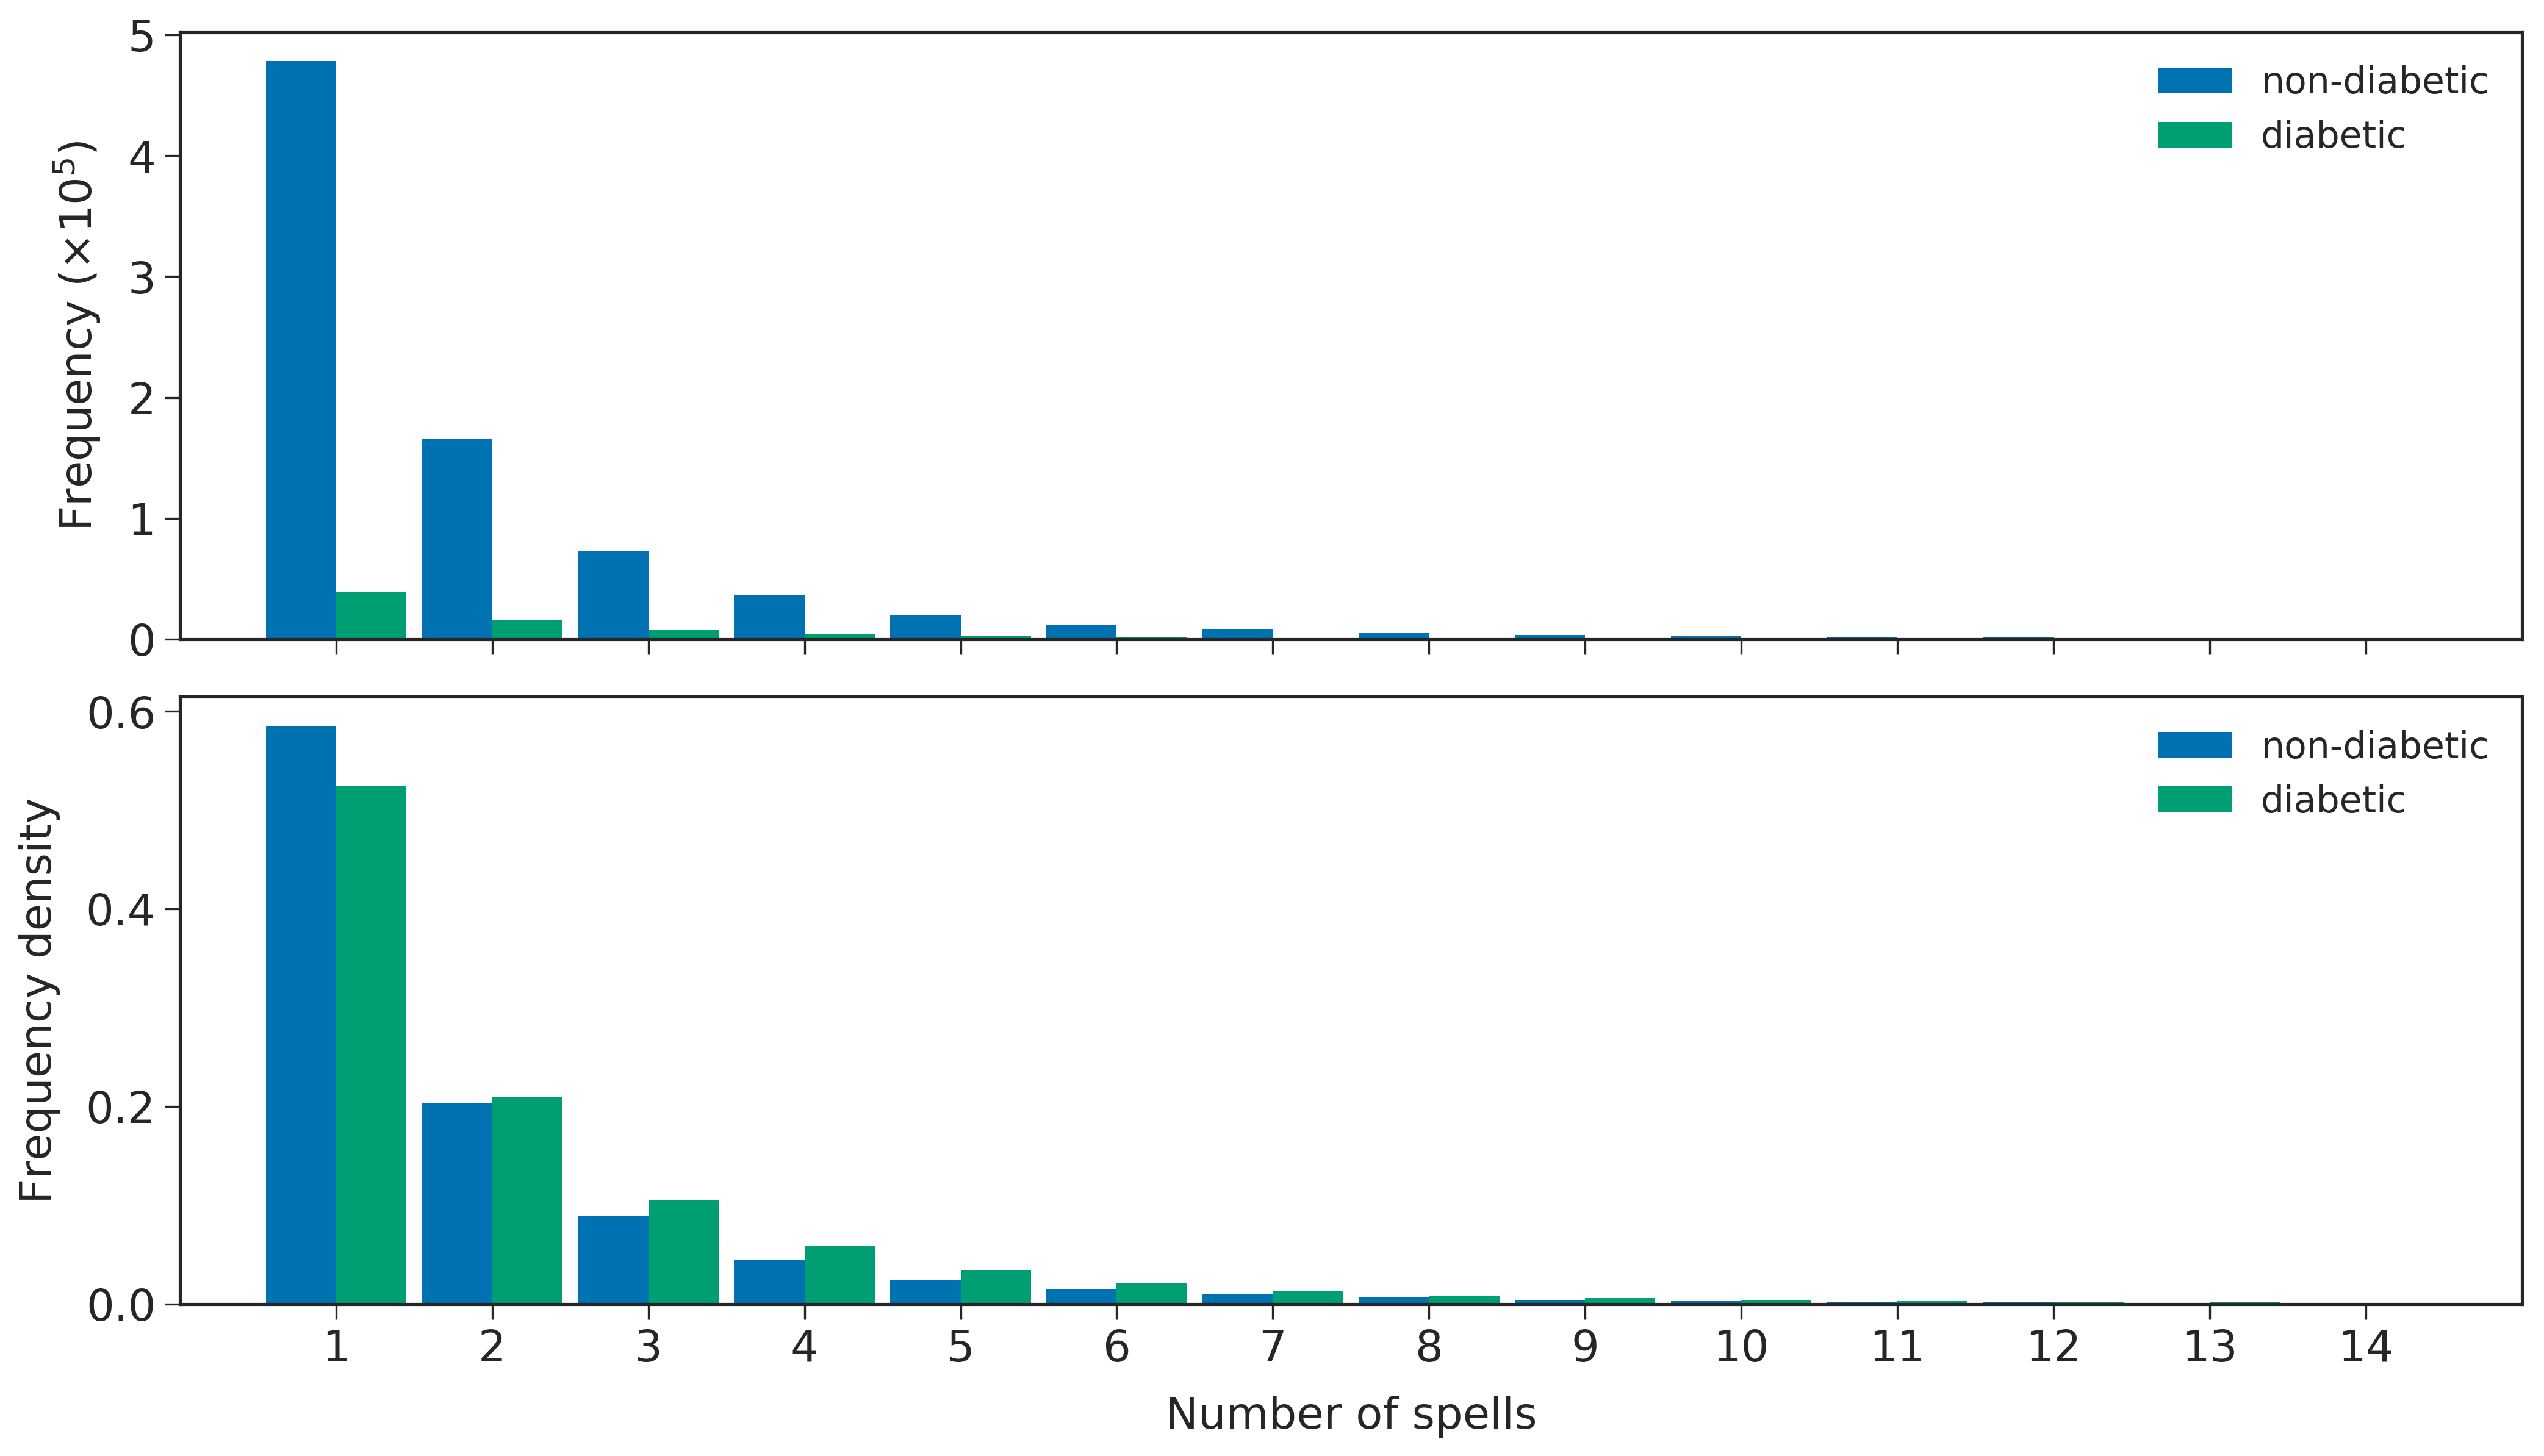

In [15]:
fig, (freq_ax, dens_ax) = plt.subplots(2, figsize=(14, 8), dpi=300, sharex=True)
width = 0.45

for data, label, shift in zip(
    [nondiab_nspells, diab_nspells],
    ['non-diabetic', 'diabetic'],
    [-.5 * width, .5 * width]
):

    data = Counter(data)
    freq_ax.bar(
        np.array(list(data.keys())) + shift,
        np.array(list(data.values())) / 1e5,
        width=width,
        label=label
    )

    dens_ax.bar(
        np.array(list(data.keys())) + shift,
        np.array(list(data.values())) / sum(data.values()),
        width=width,
        label=label
    )

dens_ax.set_xlabel("Number of spells")    

for ax, label in zip(
    [freq_ax, dens_ax], [r'Frequency ($\times 10^5$)', 'Frequency density']
):
    ax.set_ylabel(label)
    ax.legend()
#     ax.set_xlim(0, 14)
    ax.set_xticks(range(1, 15))
    ax.set_xlim(0, 15)

plt.tight_layout()
plt.savefig(diabetes + "no_spells_bar/main.pdf", transparent=True);

## Length of stay

In [10]:
diab_LOS = df[df['Diabetes'] == 1].set_index('ADMDATE') \
                                                      .drop_duplicates('SPELL_ID')['TRUE_LOS'].dropna()

In [11]:
nondiab_LOS = df[df['Diabetes'] == 0].set_index('ADMDATE') \
                                                         .drop_duplicates('SPELL_ID')['TRUE_LOS'].dropna()

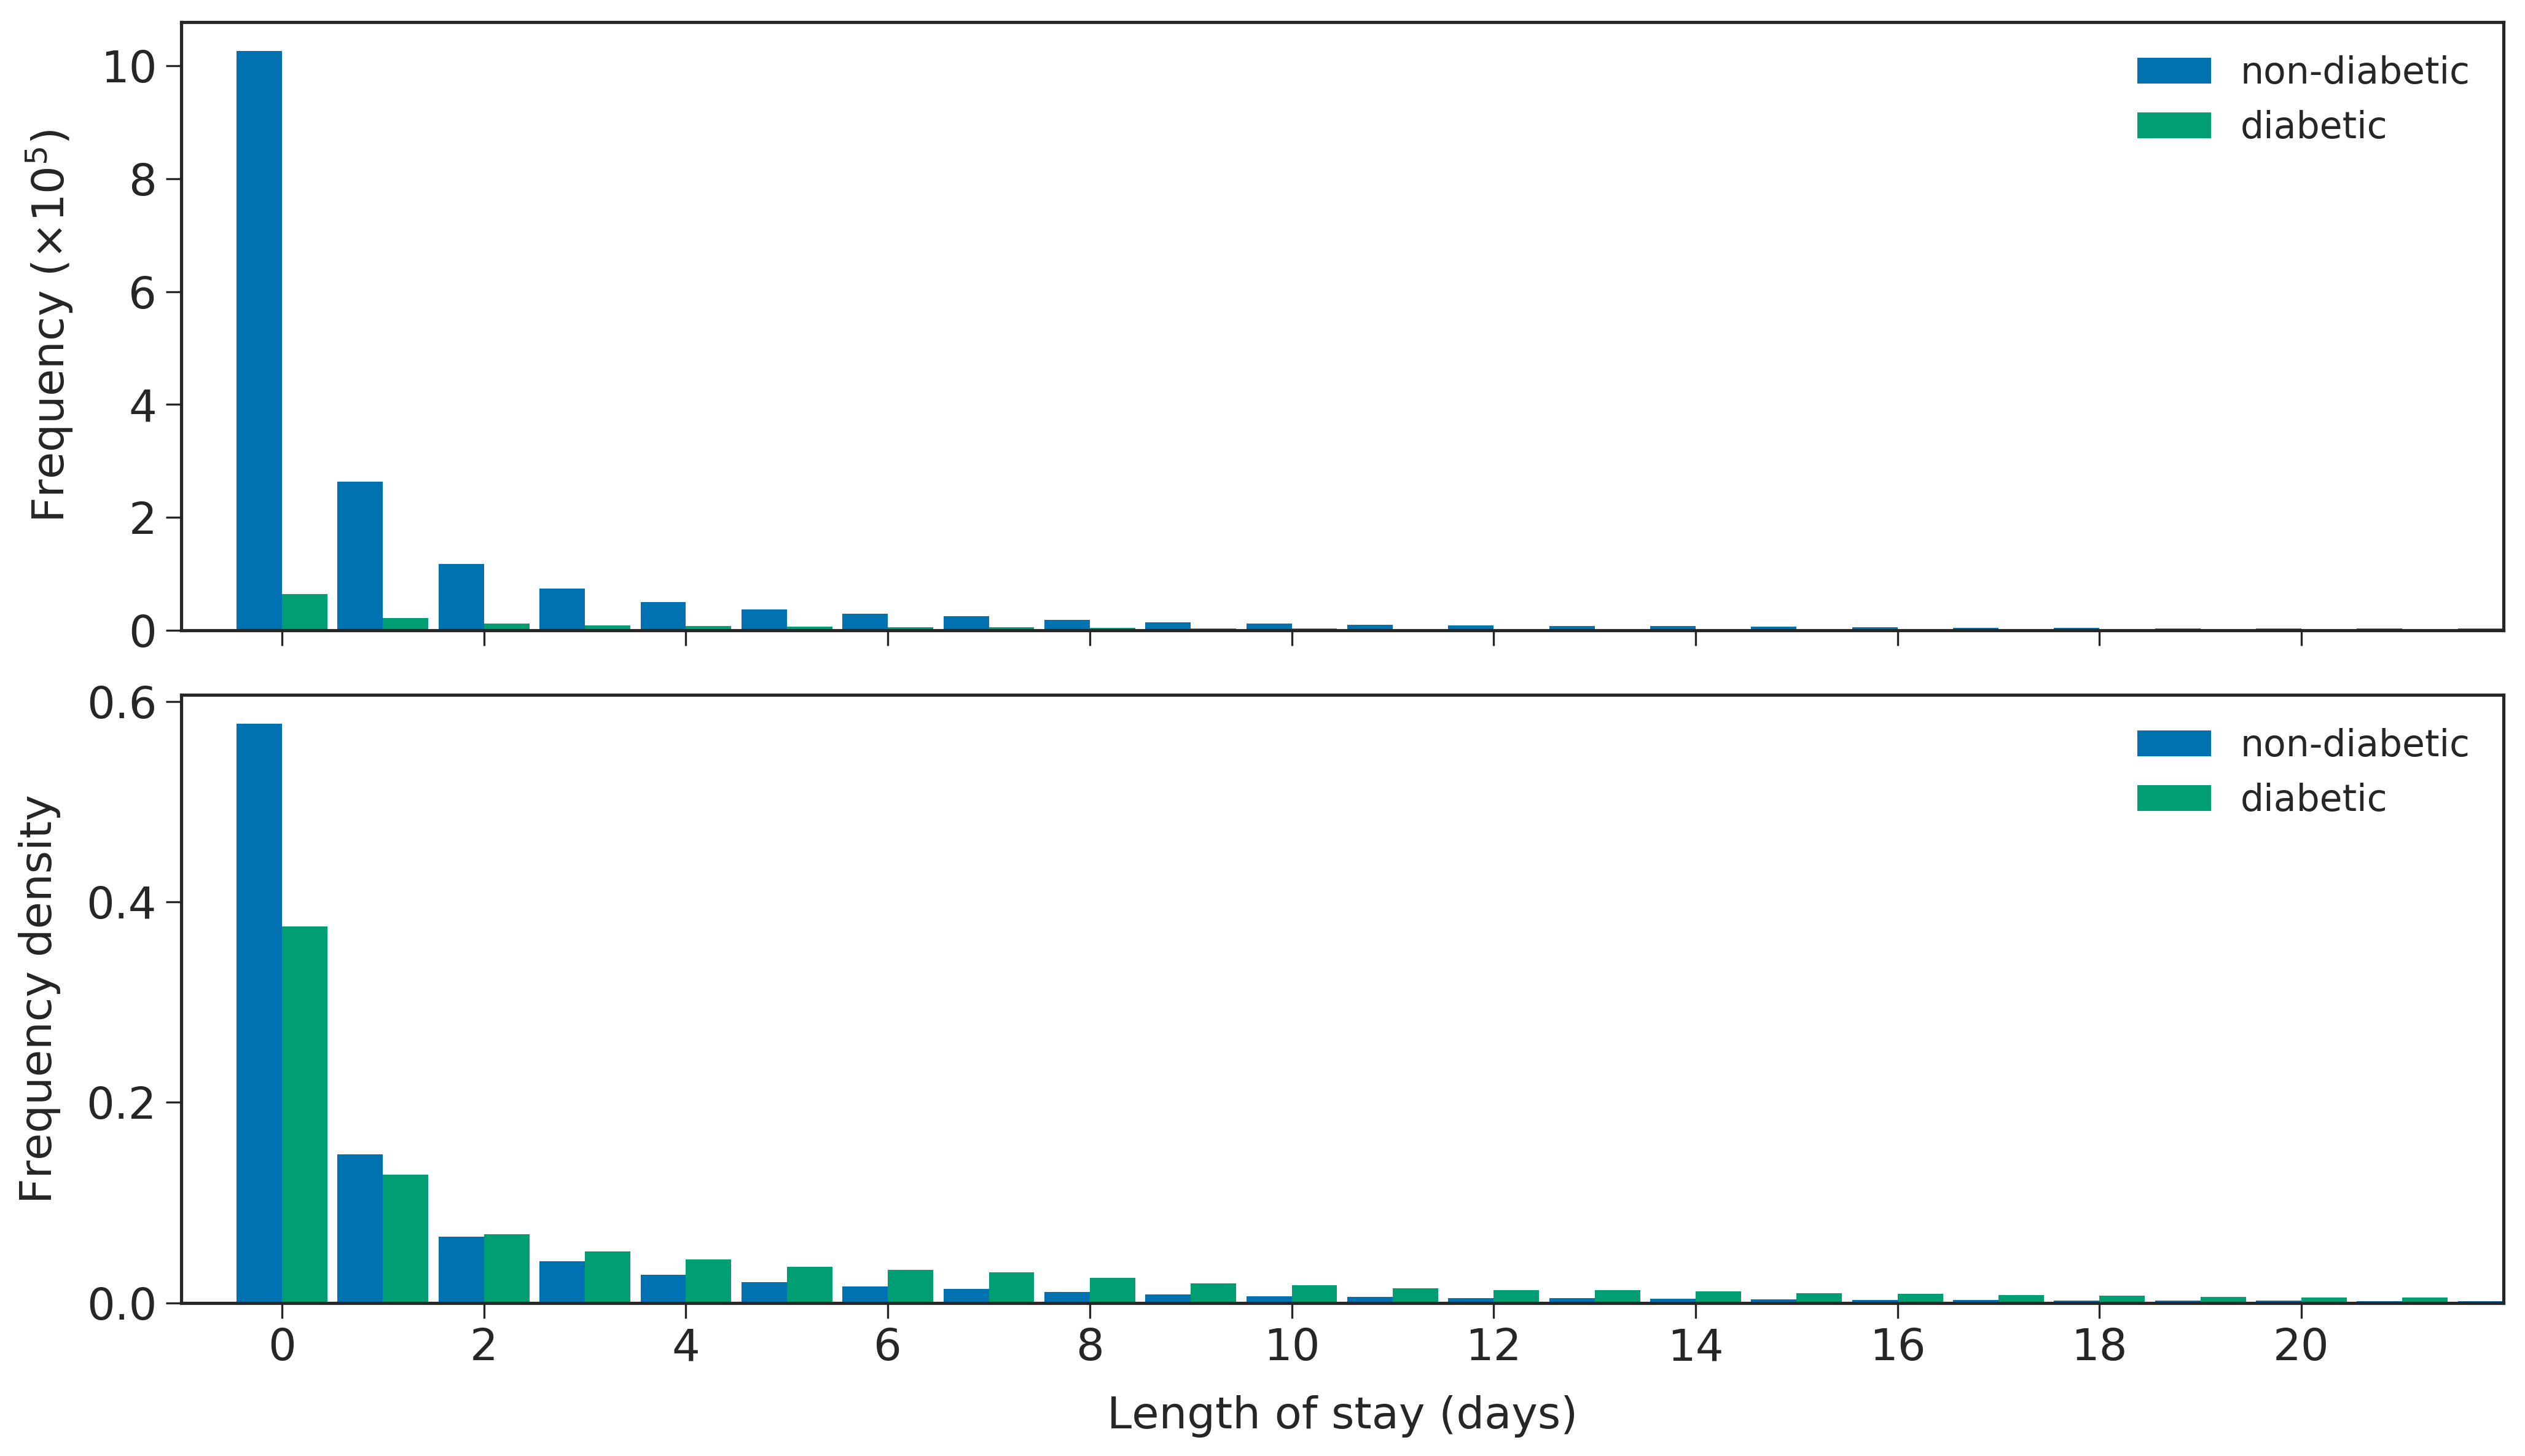

In [14]:
fig, (freq_ax, dens_ax) = plt.subplots(2, figsize=(14, 8), dpi=300, sharex=True)
width = 0.45

for data, label, shift in zip(
    [nondiab_LOS, diab_LOS],
    ['non-diabetic', 'diabetic'],
    [-.5 * width, .5 * width]
):

    data = Counter(data)
    freq_ax.bar(
        np.array(list(data.keys())) + shift,
        np.array(list(data.values())) / 1e5,
        width=width,
        label=label
    )

    dens_ax.bar(
        np.array(list(data.keys())) + shift,
        np.array(list(data.values())) / sum(data.values()),
        width=width,
        label=label
    )

dens_ax.set_xlabel("Length of stay (days)")    

for ax, label in zip(
    [freq_ax, dens_ax], [r'Frequency ($\times 10^5$)', 'Frequency density']
):
    ax.set_ylabel(label)
    ax.legend()
    ax.set_xlim(-1, 22)
    ax.set_xticks([2 * x for x in range(11)])
    ax.set_xticklabels([2 * x for x in range(11)])

plt.tight_layout()
plt.savefig(diabetes + "los_bar/main.pdf", transparent=True);

## Net cost distribution

In [ ]:
diab_netcost = df[df['Diabetes'] == 1].groupby('SPELL_ID').NetCost.sum()
nondiab_netcost = df[df['Diabetes'] == 0].groupby('SPELL_ID').NetCost.sum()

In [ ]:
fig, ax = plt.subplots(1, figsize=(14, 8), dpi=300)

for name, data in zip(['non-diabetic', 'diabetic'], [nondiab_netcost, diab_netcost]):

    steps = 300
    xs = np.linspace(data.min(), 12500, steps)

    density = gaussian_kde(data)
    ax.plot(xs, density(xs), label=name)
    ax.fill_between(xs, [0]*steps, density(xs), alpha=0.1)

ax.set_xlabel('Net cost (£)')
ax.legend()

plt.tight_layout()
plt.savefig(diabetes + "netcost_kde/main.pdf", transparent=True);

In [ ]:
dfs = []
for name, data in zip(['Non-diabetic', 'Diabetic'], [nondiab_netcost, diab_netcost]):

    summary = pd.DataFrame(
        data.describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.95, 0.99]).iloc[1:]
    ).round(2).rename({'NetCost': name}, axis=1)

    summary[name] = [f'{val:,.2f}' for val in summary[name]]
    dfs.append(summary[name])

summary = pd.concat(dfs, axis=1)

In [ ]:
summary.to_latex('/Users/henrywilde/thesis/tex/data-analysis/tex/diabetic_netcost_summary.tex')

## Maximum diagnoses

In [ ]:
diabetes_present = (df['DiabetesPrim'] == 1) | (df['DiabetesSec'] == 1)
df['Diabetes'] = np.where(diabetes_present, 1, 0)

In [ ]:
fig, (freq_ax, dens_ax) = plt.subplots(2, figsize=(14, 8), dpi=300, sharex=True)

diab_nums = df[df["Diabetes"] == 1].groupby("SPELL_ID")["DIAG_NO"].max()
nondiab_nums = df[df["Diabetes"] == 0].groupby("EPISODE_ID")["DIAG_NO"].max()
width = 0.45

for data, label, shift in zip(
    [nondiab_nums, diab_nums],
    ['non-diabetic', 'diabetic'],
    [-.5 * width, .5 * width]
):

    data = Counter(data)
    freq_ax.bar(
        np.array(list(data.keys())) + shift,
        np.array(list(data.values())) / 1e5,
        width=width,
        label=label
    )

    dens_ax.bar(
        np.array(list(data.keys())) + shift,
        np.array(list(data.values())) / sum(data.values()),
        width=width,
        label=label
    )

dens_ax.set_xlabel("Maximum number of diagnoses")    

for ax, label in zip(
    [freq_ax, dens_ax], [r'Frequency ($\times 10^5$)', 'Frequency density']
):
    ax.set_ylabel(label)
    ax.legend()
    ax.set_xticks(range(14))
    ax.set_xticklabels(list(range(13)) + [r'$\geq$13'])

plt.tight_layout()
plt.savefig(diabetes + "no_diag_bar/main.pdf", transparent=True);

## Procedure numbers

In [ ]:
fig, (freq_ax, dens_ax) = plt.subplots(2, figsize=(14, 8), dpi=300, sharex=True)

diab_nums = df[df["Diabetes"] == 1].groupby("SPELL_ID")["PROC_NO"].sum()
nondiab_nums = df[df["Diabetes"] == 0].groupby("EPISODE_ID")["PROC_NO"].sum()
width = 0.45

for data, label, shift in zip(
    [nondiab_nums, diab_nums],
    ['non-diabetic', 'diabetic'],
    [-.5 * width, .5 * width]
):

    data = Counter(data)
    freq_ax.bar(
        np.array(list(data.keys())) + shift,
        np.array(list(data.values())) / 1e5,
        width=width,
        label=label
    )

    dens_ax.bar(
        np.array(list(data.keys())) + shift,
        np.array(list(data.values())) / sum(data.values()),
        width=width,
        label=label
    )

dens_ax.set_xlabel("Number of procedures")    

for ax, label in zip(
    [freq_ax, dens_ax], [r'Frequency ($\times 10^5$)', 'Frequency density']
):
    ax.set_ylabel(label)
    ax.legend()
    ax.set_xticks(range(13))
    ax.set_xlim(-1, 13)
    ax.set_xticklabels(list(range(12)) + [r'$\geq 12$'])

plt.tight_layout()
plt.savefig(diabetes + "no_proc_bar/main.pdf", transparent=True);

## Age (vs. non-diabetic)

In [ ]:
diab_ages = df[df['Diabetes'] == 1].set_index('PATIENT_ID').drop_duplicates('SPELL_ID')['Age'].dropna().values
nondiab_ages = df[df['Diabetes'] == 0].set_index('PATIENT_ID').drop_duplicates('SPELL_ID')['Age'].dropna().values

In [ ]:
fig, (freq_ax, dens_ax) = plt.subplots(2, figsize=(14, 8), dpi=300, sharex=True)

width = 0.45

for data, label, shift in zip(
    [nondiab_ages, diab_ages],
    ['non-diabetic', 'diabetic'],
    [-.5 * width, .5 * width]
):

    data = Counter(data)

    freq_ax.bar(
        np.array(list(data.keys())) + shift,
        np.array(list(data.values())) / 1e5,
        width=width,
        label=label
    )

    dens_ax.bar(
        np.array(list(data.keys())) + shift,
        np.array(list(data.values())) / sum(data.values()),
        width=width,
        label=label
    )

dens_ax.set_xlabel("Age (years)")

for ax, label in zip(
    [freq_ax, dens_ax], [r'Frequency ($\times 10^5$)', 'Frequency density']
):
    ax.set_ylabel(label)
    ax.set_xlim(-2, 105)
    ax.legend()

plt.tight_layout()
plt.savefig(diabetes + "age_bar/main.pdf", transparent=True);

# Cost components

## Correlations

In [8]:
diab_sum_costs = df[df['Diabetes'] == 1].groupby('SPELL_ID')[costs].sum()
diab_true_lengths = df[df['Diabetes'] == 1].groupby('SPELL_ID')['TRUE_LOS'].mean()
diab_max_diag = df[df['Diabetes'] == 1].groupby('SPELL_ID')['DIAG_NO'].max()
diab_sum_proc = df[df['Diabetes'] == 1].groupby('SPELL_ID')['PROC_NO'].sum()

diab_data = pd.concat([diab_sum_costs, diab_true_lengths, diab_max_diag, diab_sum_proc], axis=1)

In [9]:
nondiab_sum_costs = df[df['Diabetes'] == 0].groupby('SPELL_ID')[costs].sum()
nondiab_true_lengths = df[df['Diabetes'] == 0].groupby('SPELL_ID')['TRUE_LOS'].mean()
nondiab_max_diag = df[df['Diabetes'] == 0].groupby('SPELL_ID')['DIAG_NO'].max()
nondiab_sum_proc = df[df['Diabetes'] == 0].groupby('SPELL_ID')['PROC_NO'].sum()

nondiab_data = pd.concat([nondiab_sum_costs, nondiab_true_lengths, nondiab_max_diag, nondiab_sum_proc], axis=1)

In [ ]:
diab_summative = diab_data.describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.99])
diab_summative = diab_summative.iloc[1:, :].apply(lambda x: [f"{val:,.2f}" for val in x])

In [ ]:
nondiab_summative = nondiab_data.describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.99])
nondiab_summative = nondiab_summative.iloc[1:, :].apply(lambda x: [f"{val:,.2f}" for val in x])

In [ ]:
diab_summative

In [ ]:
nondiab_summative

In [ ]:
combined_summative = pd.DataFrame(columns=diab_summative.columns, index=diab_summative.index)
for i in range(len(diab_summative)):
    for j in range(len(diab_summative.columns)):
        combined_summative.iloc[i, j] = diab_summative.iloc[i, j] + f" ({nondiab_summative.iloc[i, j]})"

In [ ]:
combined_summative

In [ ]:
bottom = 0
for i in range(6):
    top = bottom + 5
    combined_summative.iloc[:, bottom:top].to_latex(f"../tex/data-analysis/tex/diab_summative_stats{i}.tex")
    bottom = top

In [13]:
diab_correlation = diab_data.corr().round(2)

order = sorted(diab_correlation.columns, key=lambda col: abs(diab_correlation[col]).sum())[::-1]
diab_correlation = diab_correlation[order].reindex(order)

In [ ]:
fig, ax = plt.subplots(1, figsize=(16, 12), dpi=400)

sbn.heatmap(diab_correlation, square=True, cmap='viridis', center=0, vmin=-1, vmax=1,
            linewidths=0.1, annot=True, annot_kws={'fontsize': 8}, ax=ax)

for label in ax.get_xticklabels():
    label.set_rotation(60)
    label.set_horizontalalignment('right');

plt.tight_layout()
plt.savefig(diabetes + "corr_heatmap/with_nums.pdf", transparent=True);

## p-values for correlation

In [ ]:
diab_p_values = pd.DataFrame(index=diab_correlation.index, columns=diab_correlation.index)
for c1 in diab_data.columns:
    for c2 in diab_data.columns:
        diab_p_values.loc[c1, c2] = np.round(scipy.stats.pearsonr(diab_data[c1], diab_data[c2])[1], 4)

In [ ]:
diab_p_values = diab_p_values.astype(float)

In [ ]:
diab_sig = np.where(diab_p_values.values < 0.05, True, False)
diab_sig = pd.DataFrame(diab_sig, index=diab_p_values.index, columns=diab_p_values.columns)

In [ ]:
fig, ax = plt.subplots(1, figsize=(12, 10), dpi=400)

sbn.heatmap(diab_sig, square=True, cmap='viridis', lw=0.01, annot=True, annot_kws={'fontsize': 5}, ax=ax)

for label in ax.get_xticklabels():
    label.set_rotation(45)
    label.set_horizontalalignment('right');

In [ ]:
fig, ax = plt.subplots(1, figsize=(12, 10), dpi=400)

sbn.heatmap(diab_p_values, square=True, cmap='viridis', lw=0.01, annot=False, annot_kws={'fontsize': 5}, ax=ax)

for label in ax.get_xticklabels():
    label.set_rotation(45)
    label.set_horizontalalignment('right');

## Difference in correlation

In [ ]:
differences = diab_correlation - correlation[order].reindex(order)

diff_order = sorted(differences.columns, key=lambda col: abs(differences[col]).sum())[::-1]
differences = differences[diff_order].reindex(diff_order)

In [ ]:
fig, ax = plt.subplots(1, figsize=(16, 12), dpi=400)

sbn.heatmap(differences, square=True, cmap='BrBG', center=0,
            linewidths=0.1, annot=True, annot_kws={'fontsize': 8}, ax=ax)

for label in ax.get_xticklabels():
    label.set_rotation(60)
    label.set_horizontalalignment('right');

plt.tight_layout()
plt.savefig(diabetes + 'corr_difference/with_nums.pdf', transparent=True);

## Variation

In [10]:
diab_costs = df[df['Diabetes'] == 1].groupby('SPELL_ID')[costs].sum()
nondiab_costs = df[df['Diabetes'] == 0].groupby('SPELL_ID')[costs].sum()

In [18]:
diab_var = diab_costs.std() / diab_costs.mean()
nondiab_var = nondiab_costs.std() / nondiab_costs.mean()

combined_variations = pd.concat([nondiab_var, diab_var, var], axis=1) \
                        .rename({0: 'nondiab', 1: 'diab'}, axis=1) \
                        .sort_values('nondiab', ascending=False)

combined_variations = combined_variations.reindex(order).dropna()

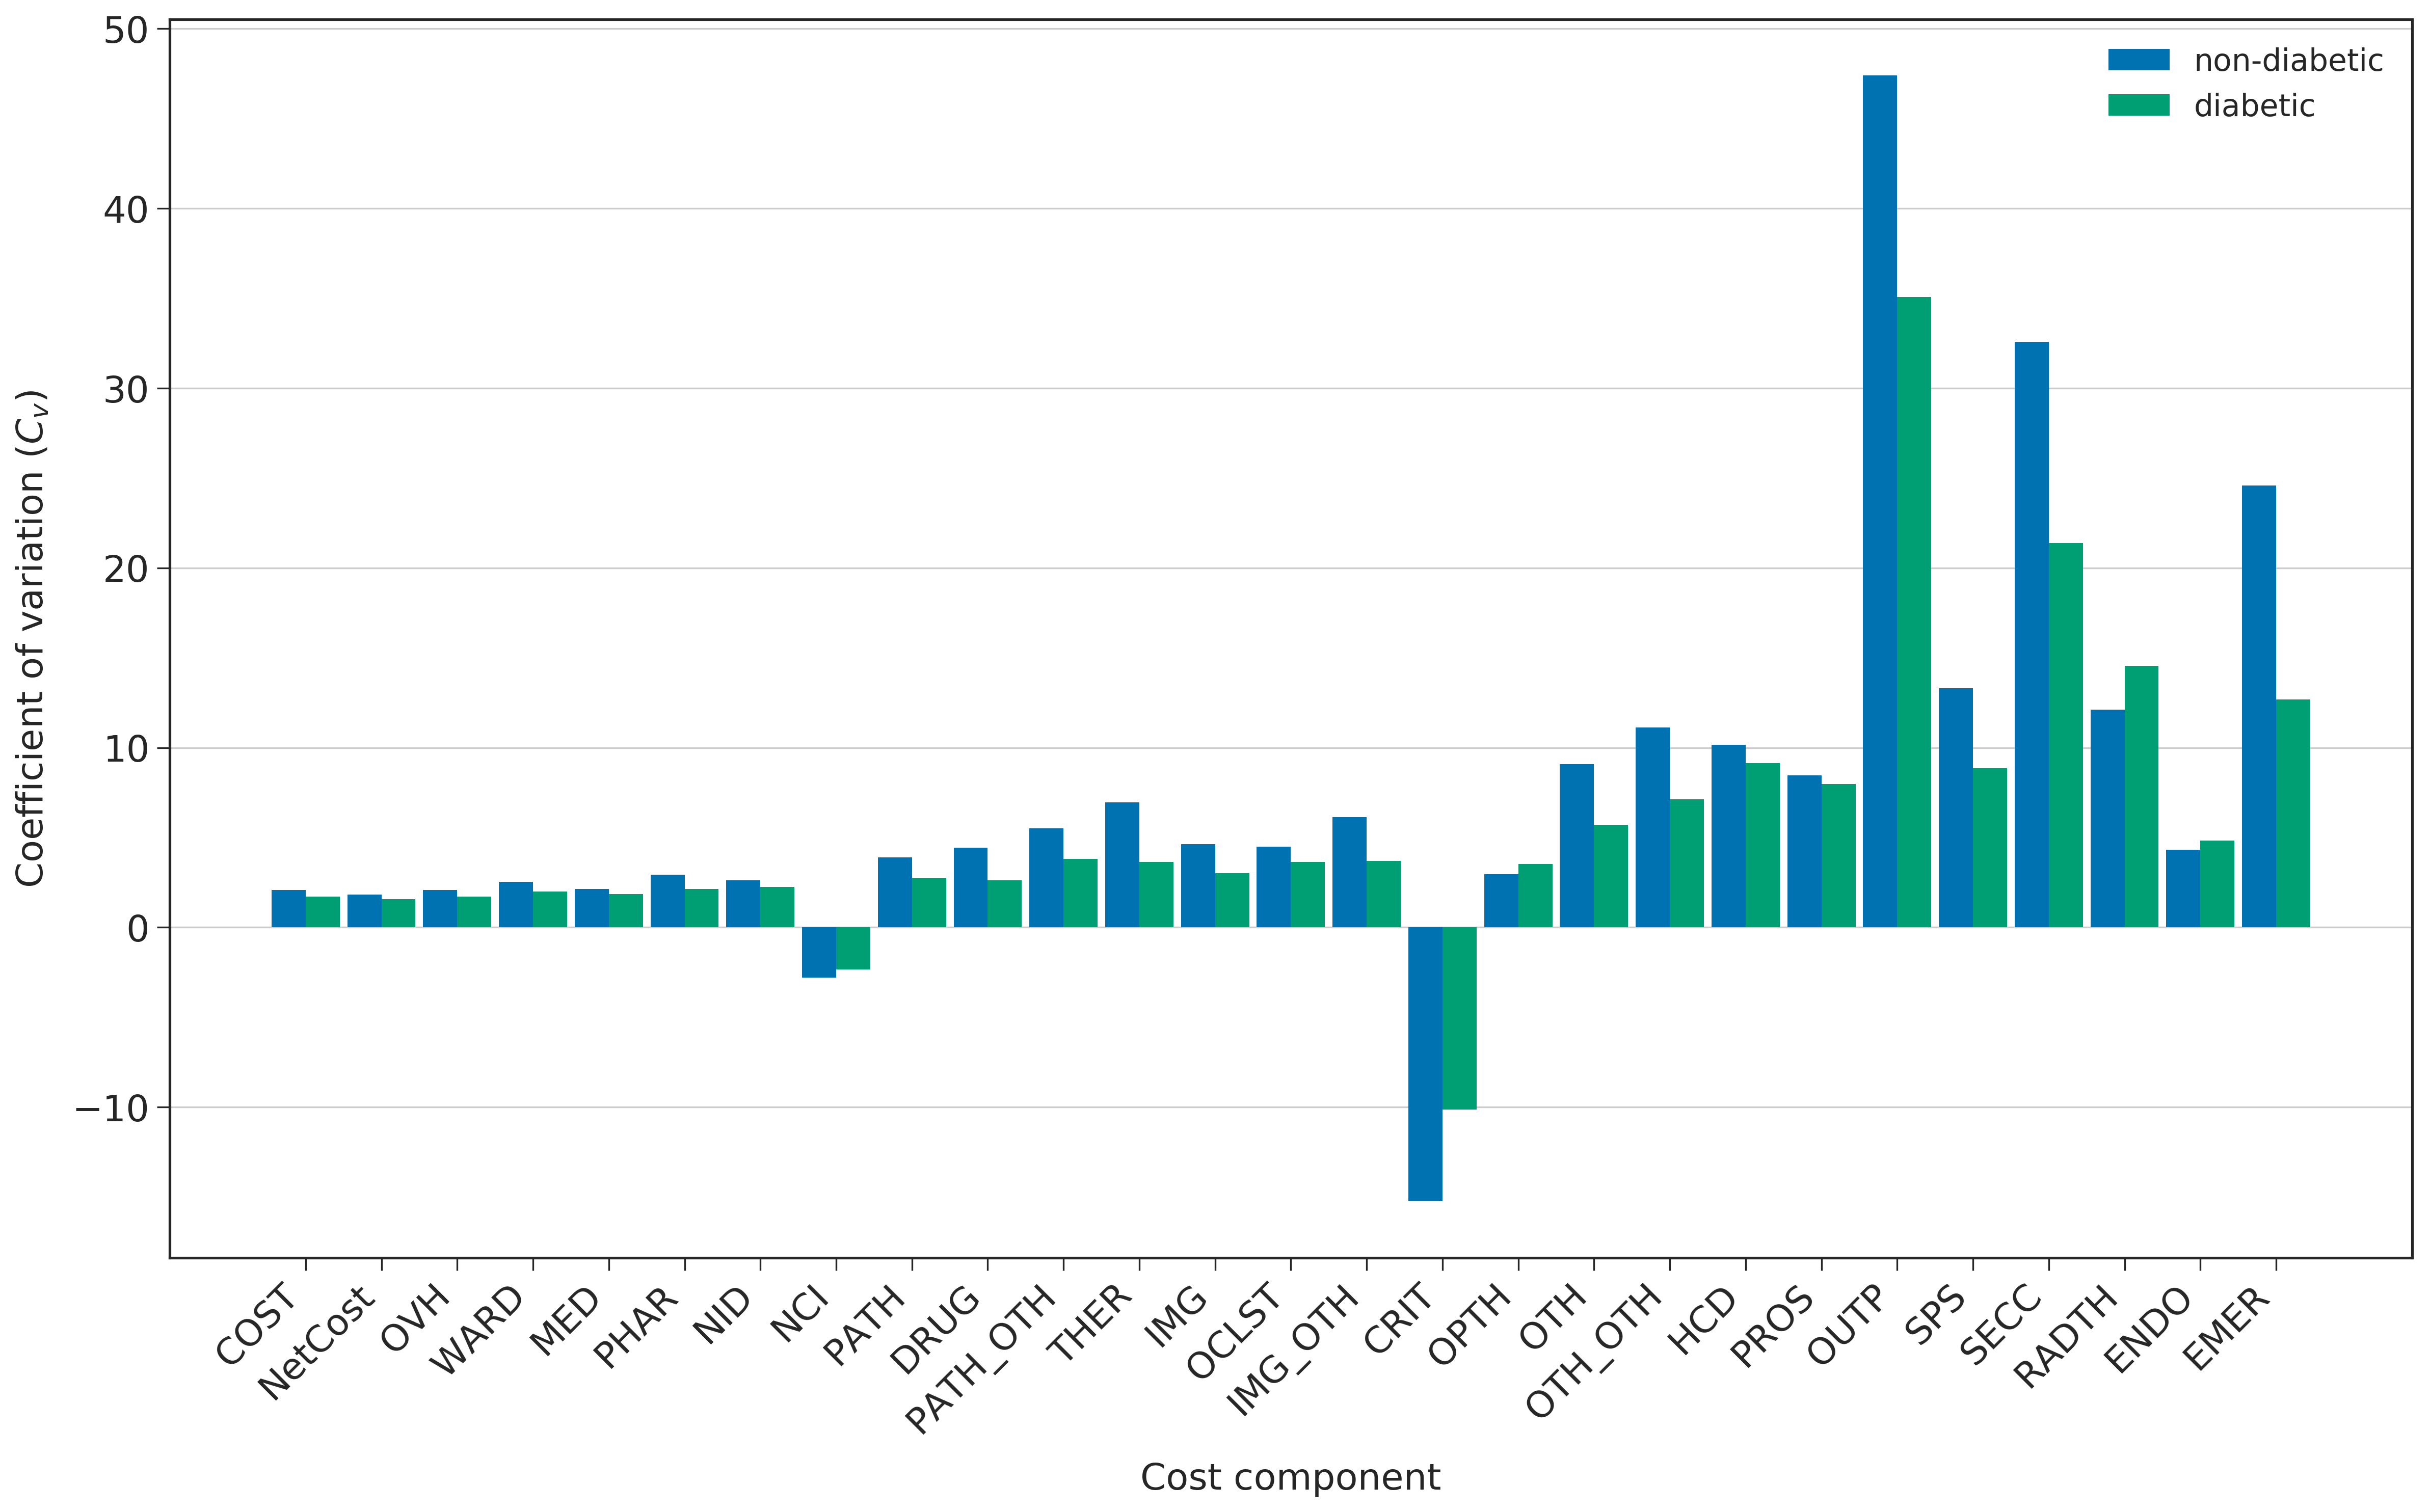

In [20]:
fig, ax = plt.subplots(1, figsize=(16, 10), dpi=300)

width = .45
inds = np.arange(len(combined_variations))

ax.bar(inds-.5*width, combined_variations['nondiab'].values, width, label='non-diabetic')
ax.bar(inds+.5*width, combined_variations['diab'].values, width, label='diabetic')

ax.set_xticks(inds)
ax.set_xticklabels(combined_variations.index)
ax.set_xlabel("Cost component")
ax.set_ylabel(r'Coefficient of variation ($C_v$)')
ax.legend()

ax.set_axisbelow(True)
ax.grid(b=True, which='major', axis='y')

for label in ax.get_xticklabels():
    label.set_rotation(45)
    label.set_horizontalalignment('right')
    
plt.tight_layout()
plt.savefig(diabetes + "cost_variation/main.pdf", transparent=True);

## Cost component contribution

In [ ]:
diab_contributions = diab_costs[
    [c for c in costs if c not in ['COST', 'NetCost']]
].divide(diab_costs['NetCost'], axis=0).mean()

nondiab_contributions = nondiab_costs[
    [c for c in costs if c not in ['COST', 'NetCost']]
].divide(nondiab_costs['NetCost'], axis=0).mean()

In [ ]:
combined_contributions = pd.concat([diab_contributions, nondiab_contributions], axis=1) \
                           .rename({0: 'diab', 1: 'nondiab'}, axis=1) \
                           .sort_values('nondiab', ascending=False)

combined_contributions = combined_contributions.reindex(order).dropna()

In [ ]:
fig, ax = plt.subplots(1, figsize=(16, 10), dpi=300)

width = 0.45
inds = np.arange(len(combined_contributions))

ax.bar(inds-.5*width, combined_contributions['nondiab'].values, width, label='non-diabetic')
ax.bar(inds+.5*width, combined_contributions['diab'].values, width, label='diabetic')

ax.set_xticks(inds)
ax.set_xticklabels(combined_contributions.index)
ax.set_xlabel("Cost component")
ax.set_ylabel('Average proportion of net cost')
ax.legend()

ax.set_axisbelow(True)
ax.grid(b=True, which='major', axis='y')

for label in ax.get_xticklabels():
    label.set_rotation(45)
    label.set_horizontalalignment('right')

plt.tight_layout()
plt.savefig(diabetes + 'cost_contribution/main.pdf', transparent=True);

## Contribution vs. variation

In [ ]:
diab_cont_var_df = pd.concat([combined_contributions['diab'], combined_variations['diab']], axis=1).dropna()
diab_cont_var_df.columns = ['proportion', 'variation']
diab_cont_var_df = diab_cont_var_df.reindex(order).dropna()

nondiab_cont_var_df = pd.concat([combined_contributions['nondiab'], combined_variations['nondiab']], axis=1).dropna()
nondiab_cont_var_df.columns = ['proportion', 'variation']

nondiab_cont_var_df = nondiab_cont_var_df.reindex(order).dropna()

In [ ]:
fig, (ax, size_ax) = plt.subplots(ncols=2, figsize=(24, 12), dpi=400,
                                  gridspec_kw={'width_ratios': [16, 1]})

fontsize = 30
d_alpha = 0.5
n_alpha = 0.5

for diab_point, nondiab_point in zip(diab_cont_var_df.iterrows(), nondiab_cont_var_df.iterrows()):
    
    # Non-diabetic scatter
    nondiab_variation = abs(nondiab_point[1]['variation'])
    ax.scatter(nondiab_point[0], nondiab_point[1]['proportion'], s=nondiab_variation*1e3, facecolor=blue,
               zorder=2.5-(0.01*nondiab_variation), marker='.', edgecolor=blue, alpha=n_alpha)
    ax.scatter(nondiab_point[0], nondiab_point[1]['proportion'], zorder=2.5-(0.01*nondiab_variation),
               color=blue, marker='.', s=100)
    
    # Diabetic scatter
    diab_variation = abs(diab_point[1]['variation'])
    ax.scatter(diab_point[0], diab_point[1]['proportion'], s=diab_variation*1e3, facecolor=green,
               zorder=2.5-(0.005*diab_variation), edgecolor=green, alpha=d_alpha, marker='.')
    ax.scatter(diab_point[0], diab_point[1]['proportion'], zorder=2.5-(0.005*diab_variation),
               marker='.', color='w', s=100)

    # Guide line
    ax.vlines(diab_point[0], -1, min(diab_point[1]['proportion'], nondiab_point[1]['proportion']), 'grey', 'dotted')

# Legend elements
d1 = ax.scatter([], [], marker='o', s=100, alpha=d_alpha, edgecolor='None', facecolor=green)
d2 = ax.scatter([], [], marker='.', s=10, color='w')
n1 = ax.scatter([], [], marker='o', s=100, alpha=n_alpha, edgecolor='None', facecolor=blue)
n2 = ax.scatter([], [], marker='.', s=10, edgecolor='None', facecolor=blue)

legend = ax.legend(((n1, n2), (d1, d2)), (('non-diabetic'), ('diabetic')),
                   loc='best', fontsize=fontsize * .8, markerscale=2.5)

sizes = [2, 5, 10, 25, 40]
for i, size in enumerate(sizes):
    size_ax.scatter([], [], marker='.', s=size*1e3, alpha=(n_alpha+d_alpha)/2,
                    facecolor=blue, edgecolor='None', label=size)

handles, labels = size_ax.get_legend_handles_labels()
size_legend = size_ax.legend(handles, labels, title=r'Coefficient of' + '\n' + 'variation ($C_v$)',
                             labelspacing=3, loc='best', fontsize=fontsize, handletextpad=3,
                             facecolor='None', edgecolor='None')

size_legend.get_title().set_fontsize(fontsize)
size_legend._legend_box.sep = 60
size_ax.set_xlim(0, 0.04)
size_ax.axis('off')

# Settings
ax.set_xlabel("Cost component", fontsize=fontsize)
ax.set_ylabel('Average proportion of net cost', fontsize=fontsize)
ax.set_ylim(-0.1, 0.3)
ax.set_xlim(-1.5, 25.5)

ax.hlines(0, *ax.get_xlim(), 'r', lw=2)

ax.set_axisbelow(True)
ax.grid(b=True, which='major', axis='y')
ax.set_yticks(ax.get_yticks()[1:-1])

for label in ax.get_yticklabels():
    label.set_fontsize(fontsize * .8)

for label in ax.get_xticklabels():
    label.set_fontsize(fontsize * .8)
    label.set_rotation(45)
    label.set_horizontalalignment('right')

plt.tight_layout()
plt.savefig(diabetes + "cost_bubble_plot/main.pdf", transparent=True);

## Diabetic admissions as a proportion of the total daily admissions

It seems intuitive to the consider what proportion of admissions our slice make up; this acts as an indicator of how resources or system costs are distributed to the subset we're interested in.

Let's calculate the number of admissions for the whole dataset and for diabetic patients each day. We do this by grouping our dataset by admission date and counting the number of unique spells for each admission date.

- Reworking the length of stay, finding the proportion of 'resources' (cost, beds, etc) that are diabetic

In [ ]:
num_admissions = df.groupby('ADMDATE').SPELL_ID.nunique() \
                                    .reset_index().rename({'SPELL_ID': 'nunique_spells'}, axis=1) \
                                    .groupby('ADMDATE').nunique_spells.sum()

In [ ]:
diab_admissions = df[df['Diabetes'] == 1].groupby('ADMDATE').SPELL_ID.nunique().reset_index() \
                                                               .rename({'SPELL_ID': 'nunique_spells'}, axis=1) \
                                                               .groupby('ADMDATE').nunique_spells.sum()

nondiab_admissions = df[df['Diabetes'] == 0].groupby('ADMDATE').SPELL_ID.nunique().reset_index() \
                                                                  .rename({'SPELL_ID': 'nunique_spells'}, axis=1) \
                                                                  .groupby('ADMDATE').nunique_spells.sum()

In [ ]:
fig, ax = plt.subplots(1, figsize=(16, 10), dpi=300)

diab_props = diab_admissions / num_admissions
diab_props.dropna(inplace=True)

monthly = diab_props.resample('BM').mean()
yearly = monthly.resample('BA-APR').mean()
yearly_err = monthly.resample('BA-APR').std().bfill()

errorbar_params = pd.DataFrame(yearly_err).rename({'nunique_spells': 'err'}, axis=1)
errorbar_params['val'] = yearly.values
errorbar_params['vmin'] = errorbar_params['val'] - errorbar_params['err']
errorbar_params['vmax'] = errorbar_params['val'] + errorbar_params['err']

data = monthly
X, y = date2num(data.index.values.reshape(-1,1)), data.values.reshape(-1,1)

lr = LinearRegression()
lr.fit(X, y)
y_pred = lr.predict(X)

r_squared = np.round(sklearn.metrics.r2_score(y, y_pred), 4)
standard_err = np.round(np.sqrt((y - y_pred) ** 2).sum() / len(y), 4)

linreg_df = pd.DataFrame(y_pred, index=data.index)

ax.errorbar(errorbar_params.index, errorbar_params['val'], errorbar_params['err'],
            capsize=8, ecolor='lightgray', linestyle='', label='Standard dev.')

ax.plot(diab_props, '.', lw=10, alpha=0.75, color='lightgray', label='Daily avg.')
ax.plot(monthly, '.', alpha=0.75, label='End of month avg.')
ax.plot(yearly, 'x', label='End of year avg.')
ax.plot(linreg_df, '-', label='Lin. regression model')

ax.annotate(
    r'$R^2 = $ ' + str(r_squared) + '\n' + r'$SE = $ ' + str(standard_err),
    ['2012-05-01', 0.12],
    fontsize=16
)

ax.set_xticks(yearly.index)
ax.set_xticklabels(['Apr ' + str(year.year) for year in yearly.index])

ax.set_xlabel('Admission date')
ax.set_ylabel('Proportion of total admissions')
ax.legend()

plt.tight_layout()
plt.savefig(diabetes + "admissions/with_data.pdf", transparent=True);

In [ ]:
fig, ax = plt.subplots(1, figsize=(14, 8))

xs = np.linspace(weekly.min(), weekly.max(), 300)
density = gaussian_kde(weekly)

ax.plot(xs, density(xs), label="KDE")
ax.hist(weekly, bins=10, density=True, label="Histogram")

param = scipy.stats.norm.fit(weekly)
norm = scipy.stats.norm(*param)

D, p = scipy.stats.kstest(weekly, "norm", param)

ax.plot(xs, norm.pdf(xs), label="norm")
ax.text(s=f"$p = {p:.4f}$", x=0.1075, y=40, fontsize=16)

ax.legend();

In [ ]:
fig, ax = plt.subplots(1, figsize=(14, 8))

lag_plot(weekly, ax=ax);

In [ ]:
fig, ax = plt.subplots(1, figsize=(16, 10), dpi=300)

diab_props = diab_admissions / num_admissions
diab_props.dropna(inplace=True)

monthly = diab_props.resample('BM').mean()
yearly = monthly.resample('BA-APR').mean()
yearly_err = monthly.resample('BA-APR').std().bfill()

errorbar_params = pd.DataFrame(yearly_err).rename({'nunique_spells': 'err'}, axis=1)
errorbar_params['val'] = yearly.values
errorbar_params['vmin'] = errorbar_params['val'] - errorbar_params['err']
errorbar_params['vmax'] = errorbar_params['val'] + errorbar_params['err']

data = monthly
X, y = date2num(data.index.values.reshape(-1,1)), data.values.reshape(-1,1)

lr = LinearRegression()
lr.fit(X, y)
y_pred = lr.predict(X)

r_squared = np.round(sklearn.metrics.r2_score(y, y_pred), 4)
standard_err = np.round(np.sqrt((y - y_pred) ** 2).sum() / len(y), 4)

linreg_df = pd.DataFrame(y_pred, index=data.index)

ax.errorbar(errorbar_params.index, errorbar_params['val'], errorbar_params['err'],
            capsize=8, ecolor='lightgray', linestyle='', label='Standard dev.')

ax.plot(monthly, '.', alpha=0.75, label='End of month avg.')
ax.plot(yearly, 'x', label='End of year avg.')
ax.plot(linreg_df, '-', label='Lin. regression model')

ax.annotate(
    r'$R^2 = $ ' + str(r_squared) + '\n' + r'$SE = $ ' + str(standard_err),
    ['2012-05-01', 0.095],
    fontsize=16
)

ax.set_xticks(yearly.index)
ax.set_xticklabels(['Apr ' + str(year.year) for year in yearly.index])

ax.set_xlabel('Admission date')
ax.set_ylabel('Proportion of total admissions')
ax.legend()

plt.tight_layout()
plt.savefig(diabetes + "admissions/main.pdf", transparent=True);

# Cost component distributions

In [ ]:
no_dist = sorted(['SPS', 'SECC', 'RADTH', 'PROS', 'OUTP', 'OTH_OTH', 'OTH', 'OPTH', 'ENDO', 'EMER', 'CRIT'])
small_dist = sorted(['OCLST', 'IMG_OTH', 'HCD'])
large_dist = sorted(['WARD', 'OVH', 'MED'])

medium_dist = sorted([c for c in costs if c not in ['NetCost', 'COST'] + no_dist + small_dist + large_dist])

In [ ]:
nondiab_contributions

In [ ]:
fig, ax = plt.subplots(1, figsize=(40, 24), dpi=400)

cols = ['DRUG', 'NID', 'OPTH']

# fontsize = 24
delta = 0.05
steps = 200
xmin, xmax = 0, 0.25
positions = np.arange(len(cols)) * 1.5
args = zip(['non-diabetic', 'diabetic'], [nondiab_contributions, diab_contributions], [blue, green], [0.3, -0.3])

patches = []
for name, dataset, colour, beta in args:

    vpstats = []
    for i, col in enumerate(cols):
        if col == 'NCI':
            xmax *= -1
        pos = positions[i] + beta
        data = dataset[col].values
        coords = np.linspace(xmin, xmax, steps)
        density = gaussian_kde(data)

        mean = np.mean(data)
        LQ = np.percentile(data, 25)
        UQ = np.percentile(data, 75)
        median = np.median(data)
        
        IQR = UQ - LQ
        lower_whisker = max(xmin, LQ-1.5*IQR)
        upper_whisker = min(xmax, UQ+1.5*IQR)
        
        if col == 'NCI':
            lower_whisker = max(xmax, LQ-1.5*IQR)
            upper_whisker = min(xmin, UQ+1.5*IQR)
            xmax *= -1

        stats = {'coords': coords, 'vals': density(coords), 'mean': mean,
                 'min': LQ, 'max': UQ, 'median': median}
        vpstats.append(stats)

        ax.hlines(pos, LQ, UQ, lw=7, color='k')
        ax.hlines(pos, lower_whisker, upper_whisker, lw=1, color='k')
        ax.vlines(lower_whisker, pos-delta, pos+delta, lw=1, color='k')
        ax.vlines(upper_whisker, pos-delta, pos+delta, lw=1, color='k')
        ax.scatter(median, pos, s=50, color='w', zorder=100)
    
    patch = mpatches.Patch(color=colour, label=name)
    patches.append(patch)
    
    ax.violin(vpstats, vert=False, positions=positions+beta, showmedians=False, showextrema=False)

ax.set_xlim(-0.01, 0.25)
ax.set_xticks(ax.get_xticks()[1:-1])
ax.set_yticks(positions)
ax.set_yticklabels(cols)#, fontsize=fontsize)
ax.set_xlabel('Proportion of net cost')#, fontsize=fontsize)
ax.legend(handles=patches, loc='best')#, fontsize=fontsize, markerscale=fontsize/8)

# for label in ax.get_xticklabels():
#     label.set_fontsize(fontsize)

plt.tight_layout()
# plt.savefig('/Users/henrywilde/thesis/tex/overview/img/diabetes/middling_component_violinplots/main.pdf', transparent=True)

In [ ]:
fig, ax = plt.subplots(1, figsize=(40, 24), dpi=400)

cols = medium_dist

fontsize = 24
delta = 0.05
steps = 200
xmin, xmax = 0, 0.25
positions = np.arange(len(cols)) * 1.5
args = zip(['non-diabetic', 'diabetic'], [nondiab_contributions, diab_contributions], [blue, green], [0.3, -0.3])

patches = []
for name, dataset, colour, beta in args:

    vpstats = []
    for i, col in enumerate(cols):
        if col == 'NCI':
            xmax *= -1
        pos = positions[i] + beta
        data = dataset[col].values
        coords = np.linspace(xmin, xmax, steps)
        density = gaussian_kde(data)

        mean = np.mean(data)
        LQ = np.percentile(data, 25)
        UQ = np.percentile(data, 75)
        median = np.median(data)
        
        IQR = UQ - LQ
        lower_whisker = max(xmin, LQ-1.5*IQR)
        upper_whisker = min(xmax, UQ+1.5*IQR)
        
        if col == 'NCI':
            lower_whisker = max(xmax, LQ-1.5*IQR)
            upper_whisker = min(xmin, UQ+1.5*IQR)
            xmax *= -1

        stats = {'coords': coords, 'vals': density(coords), 'mean': mean,
                 'min': LQ, 'max': UQ, 'median': median}
        vpstats.append(stats)

        ax.hlines(pos, LQ, UQ, lw=7, color='k')
        ax.hlines(pos, lower_whisker, upper_whisker, lw=1, color='k')
        ax.vlines(lower_whisker, pos-delta, pos+delta, lw=1, color='k')
        ax.vlines(upper_whisker, pos-delta, pos+delta, lw=1, color='k')
        ax.scatter(median, pos, s=50, color='w', zorder=100)
    
    patch = mpatches.Patch(color=colour, label=name)
    patches.append(patch)
    
    ax.violin(vpstats, vert=False, positions=positions+beta, showmedians=False, showextrema=False)

ax.set_xlim(-0.1, 0.25)
ax.set_xticks(ax.get_xticks()[1:-1])
ax.set_yticks(positions)
ax.set_yticklabels(cols, fontsize=fontsize)
ax.set_xlabel('Proportion of net cost', fontsize=fontsize)
ax.legend(handles=patches, loc='best', fontsize=fontsize, markerscale=fontsize/8)

for label in ax.get_xticklabels():
    label.set_fontsize(fontsize)

plt.savefig(img_dir + 'medium_component_violinplots.pdf');

In [ ]:
fig, ax = plt.subplots(1, figsize=(40, 24), dpi=400)

cols = large_dist

fontsize = 24
delta = 0.05
steps = 200
xmin, xmax = 0, 1
positions = np.arange(len(cols)) * 1.5
args = zip(['non-diabetic', 'diabetic'], [nondiab_contributions, diab_contributions], [blue, green], [0.3, -0.3])

patches = []
for name, dataset, colour, beta in args:

    vpstats = []
    for i, col in enumerate(cols):
        pos = positions[i] + beta
        data = dataset[col].values
        coords = np.linspace(xmin, xmax, steps)
        density = gaussian_kde(data)

        mean = np.mean(data)
        LQ = np.percentile(data, 25)
        UQ = np.percentile(data, 75)
        median = np.median(data)
        
        IQR = UQ - LQ
        lower_whisker = max(xmin, LQ-1.5*IQR)
        upper_whisker = min(xmax, UQ+1.5*IQR)

        stats = {'coords': coords, 'vals': density(coords), 'mean': mean,
                 'min': LQ, 'max': UQ, 'median': median}
        vpstats.append(stats)

        ax.hlines(pos, LQ, UQ, lw=7, color='k')
        ax.hlines(pos, lower_whisker, upper_whisker, lw=1, color='k')
        ax.vlines(lower_whisker, pos-delta, pos+delta, lw=1, color='k')
        ax.vlines(upper_whisker, pos-delta, pos+delta, lw=1, color='k')
        ax.scatter(median, pos, s=50, color='w', zorder=100)
    
    patch = mpatches.Patch(color=colour, label=name)
    patches.append(patch)
    
    ax.violin(vpstats, vert=False, positions=positions+beta, showmedians=False, showextrema=False)

ax.set_yticks(positions)
ax.set_yticklabels(cols, fontsize=fontsize)
ax.set_xlabel('Proportion of net cost', fontsize=fontsize)
ax.legend(handles=patches, loc='best', fontsize=fontsize, markerscale=fontsize/8)

for label in ax.get_xticklabels():
    label.set_fontsize(fontsize)

plt.savefig('/Users/henrywilde/thesis/tex/overview/img/diabetes/large_component_violinplots/main.pdf', transparent=True);

## Diabetic net costs as a proportion of total daily costs

The simplest and most immediate measure of the relative resources used by diabetic patients (or any other slice of interest in the future) is the contribution they make to the total net cost of treating patients each day. As our data is episode-based rather than daily, we have to manipulate the data to be "daily".

This process will be done by grouping our data by admission date and summing the net costs of all the episodes where the patient in question was admitted on that particular day. Obviously, this will lead to a degree of misrepresentation in our plot as patients who stay for a long time incur higher costs and these will not be fairly distributed across their stay but rather the date of their admission.

Again, we trim the data to only include our previously defined date range.

In [ ]:
diab_costs = df[df['Diabetes'] == 1].groupby('ADMDATE')[costs].sum()
nondiab_costs = df[df['Diabetes'] == 0].groupby('ADMDATE')[costs].sum()
total_costs = df.groupby('ADMDATE')[costs].sum()

In [ ]:
fig, ax = plt.subplots(1, figsize=(16, 10), dpi=300)

diab_props = diab_costs.NetCost / total_costs.NetCost
diab_props.dropna(inplace=True)

monthly = diab_props.resample('BM').mean()
yearly = monthly.resample('BA-APR').mean()
yearly_err = monthly.resample('BA-APR').std().bfill()

errorbar_params = pd.DataFrame(yearly_err).rename({'NetCost': 'err'}, axis=1)
errorbar_params['val'] = yearly.values
errorbar_params['vmin'] = errorbar_params['val'] - errorbar_params['err']
errorbar_params['vmax'] = errorbar_params['val'] + errorbar_params['err']


data = monthly
X, y = date2num(data.index.values.reshape(-1,1)), data.values.reshape(-1,1)

lr = LinearRegression()
lr.fit(X, y)
y_pred = lr.predict(X)

r_squared = np.round(sklearn.metrics.r2_score(y, y_pred), 4)
standard_err = np.round(np.sqrt((y - y_pred) ** 2).sum() / len(y), 4)

linreg_df = pd.DataFrame(lr.predict(X), index=data.index)

ax.errorbar(errorbar_params.index, errorbar_params['val'], errorbar_params['err'],
            capsize=8, alpha=0.25, ecolor='k', linestyle='', label='Standard dev.')
ax.plot(monthly, '.', alpha=0.75, label='End of month avg.')
ax.plot(yearly, 'x', label='End of year avg.')
ax.plot(linreg_df, '-', label='Lin. regression model')

ax.annotate(
    r'$R^2 = $ ' + str(r_squared) + '\n' + r'$SE = $ ' + str(standard_err),
    ['2012-05-01', 0.1445],
    fontsize=16
)

ax.set_xticks(yearly.index)
ax.set_xticklabels(['Apr ' + str(year.year) for year in yearly.index])
ax.set_xlabel('Admission date')
ax.set_ylabel('Proportion of total net costs')
ax.legend(loc='upper left')

plt.tight_layout()
plt.savefig(diabetes + "netcost_proportions/main.pdf", transparent=True);

In [ ]:
diab_cost_pp = diab_costs.divide(diab_admissions, axis=0)
nondiab_cost_pp = nondiab_costs.divide(nondiab_admissions, axis=0)
general_cost_pp = total_costs.divide(num_admissions, axis=0)

In [ ]:
fig, ax = plt.subplots(1, figsize=(14, 8), dpi=300)

ax.boxplot([diab_cost_pp['NetCost'].values,
            nondiab_cost_pp['NetCost'].values,
            general_cost_pp['NetCost'].values],
           positions=[1, 2, 3], sym='.', showmeans=True, notch=True, vert=False)

ax.set_xlabel('Average net cost per person (by admission date)')
ax.set_yticks([1, 2, 3])
ax.set_yticklabels(['Diabetic', 'Non-diabetic', 'General']);

# plt.savefig(img_dir + 'diabetic_netcost_boxplot.pdf');

In [ ]:
fig, ax = plt.subplots(1, figsize=(14, 8), dpi=300)

ax.boxplot([diab_cost_pp['MED'].values,
            nondiab_cost_pp['MED'].values,
            general_cost_pp['MED'].values],
           positions=[1, 2, 3], sym='.', showmeans=True, notch=True, vert=False)

ax.set_xlabel('Average medical cost per person (by admission date)')
ax.set_yticks([1, 2, 3])
ax.set_yticklabels(['Diabetic', 'Non-diabetic', 'General']);

# plt.savefig(img_dir + 'diabetic_MEDcost_boxplot.pdf');

## Average length of stay by admission date for diabetic patients

Let us investigate how average the length of stay for our patients develop over time. Here we contrast the average length of stay for patients in a single spell (i.e. the total length of their episodes) for diabetic patients, non-diabetic patients and the general population. This incurs the same kind of misrepresentation as the proportion analysis above.

In [ ]:
fig, ax = plt.subplots(1, figsize=(16, 10), dpi=300)

monthly = diab_LOS.resample('BM').mean()
monthly = monthly.loc[monthly.index < '2017-02']
yearly = diab_LOS.resample('BA-APR').mean()
yearly_err = monthly.resample('BA-APR').std().bfill()

errorbar_params = pd.DataFrame(yearly_err).rename({'TRUE_LOS': 'err'}, axis=1)
errorbar_params['val'] = yearly.values
errorbar_params['vmin'] = errorbar_params['val'] - errorbar_params['err']
errorbar_params['vmax'] = errorbar_params['val'] + errorbar_params['err']

data = monthly
X, y = date2num(monthly.index.values.reshape(-1,1)), monthly.values.reshape(-1,1)

lr = LinearRegression()
lr.fit(X, y)
y_pred = lr.predict(X)

r_squared = np.round(sklearn.metrics.r2_score(y, y_pred), 4)
standard_err = np.round(np.sqrt((y - y_pred) ** 2).sum() / len(y), 4)

linreg_df = pd.DataFrame(y_pred, index=monthly.index)

ax.errorbar(errorbar_params.index, errorbar_params['val'], errorbar_params['err'],
            capsize=8, alpha=0.25, ecolor='k', linestyle='', label='Standard dev.')
ax.plot(monthly, '.', alpha=0.75, label='End of month avg.')
ax.plot(yearly, 'x', label='End of year avg.')
ax.plot(linreg_df, '-', label='Lin. regression model')

ax.annotate(
    r'$R^2 = $ ' + str(r_squared) + '\n' + r'$SE = $ ' + str(standard_err),
    ['2016-09-01', 7.4],
    fontsize=16
)

ax.set_xticks(yearly.index)
ax.set_xticklabels(['Apr ' + str(year.year) for year in yearly.index])

ax.set_xlabel('Admission date')
ax.set_ylabel('Average length of stay (days)')
ax.legend();

plt.tight_layout()
plt.savefig(diabetes + "los_time/main.pdf", transparent=True);